<a href="https://colab.research.google.com/github/rafadlima/python_financas/blob/main/Notebook/Long_and_Short_Cointegra%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importando as Bibliotecas**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from pandas_datareader import data
import plotly.express as px
import numpy as np

!pip install yfinance
import yfinance as yf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 6.4 MB 35.3 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


**Obtendo as cotações dos últimos 12 meses**

In [ ]:
#Obtendo dados das Cotação 1 Anos
start_date = "2021-03-20"
end_date = "2022-03-24"
stock1 = "PETR3.SA"
stock2 = "PETR4.SA"

df = yf.download([stock1, stock2], start = start_date, end = end_date)["Close"]
df.columns=[stock1,stock2]
df

[*********************100%***********************]  2 of 2 completed


,PETR3.SA,PETR4.SA
Date,,
2021-03-22,23.080000,23.520000
2021-03-23,22.549999,22.799999
2021-03-24,22.530001,22.820000
2021-03-25,22.959999,23.200001
2021-03-26,23.299999,23.459999
...,...,...
2022-03-17,32.869999,30.010000
2022-03-18,33.160000,30.610001
2022-03-21,34.270000,31.760000


**Verificando os dados dos Ativos**

In [ ]:
#Verificando e tratando dados nulos
df.isnull().sum()
df.dropna(inplace=True)

Text(0.5, 1.0, 'PETR3.SA & PETR4.SA')

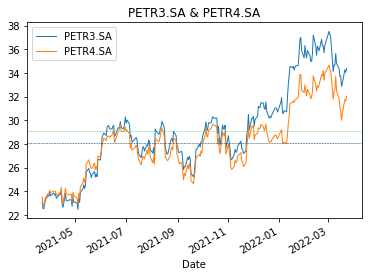

In [ ]:
#Verificando o comportamento dos dois ativos no período selecionado
mean_stock1 = df[stock1].mean()
mean_stock2 = df[stock2].mean()


df[[stock1, stock2]].plot(linewidth=1)
plt.axhline(y=mean_stock1, color='#49ce8b', linestyle='--', linewidth=0.5)
plt.axhline(y=mean_stock2, color='#033660', linestyle='--', linewidth=0.5)

plt.title(stock1 + " & " + stock2)

**Analise de Cointegração**

In [ ]:
# Verificando a Correlação entre eles
df.corr()

,PETR3.SA,PETR4.SA
PETR3.SA,1.000000,0.985444
PETR4.SA,0.985444,1.000000


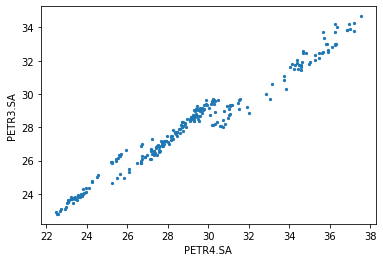

In [ ]:
plt.scatter(df[stock1], df[stock2], s=5)
plt.xlabel(stock2)
plt.ylabel(stock1)
plt.show()

In [ ]:
# Regressão Linear

# Convertendo os valores em numpy array
X_independent = df.iloc[:,1].values.reshape(-1, 1)
Y_dependent = df.iloc[:,0].values.reshape(-1, 1) 

reg = LinearRegression().fit(X_independent, Y_dependent)

# get beta (angular coef of the linear regression)
beta = reg.coef_;
print('beta = %f' % beta)

# get b coef from (beta*x + b) of the linear regression)
b = reg.intercept_;
print('b = %f' % b)

# get the estimated Y values given X from the model
Y_predict = reg.predict(X_independent);

beta = 1.339944
b = -8.510691


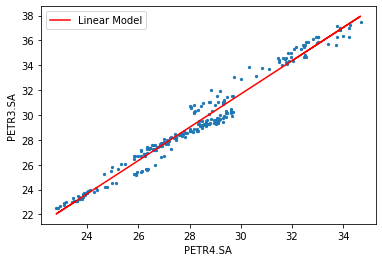

In [ ]:
# Platando o gráfico com regressão linear
plt.scatter(X_independent, Y_dependent, s=5)

plt.plot(X_independent, Y_predict, color="red", label='Linear Model')

plt.xlabel(stock2)
plt.ylabel(stock1)
plt.legend()
plt.show()

In [ ]:
#Gerando o Residuo da Regressão
df['Residual'] = Y_dependent - Y_predict
df = df.rename_axis(['Date']).reset_index()
df


,Date,PETR3.SA,PETR4.SA,Residual
0,2021-03-22,23.080000,23.520000,0.075211
1,2021-03-23,22.549999,22.799999,0.509972
2,2021-03-24,22.530001,22.820000,0.463174
3,2021-03-25,22.959999,23.200001,0.383992
4,2021-03-26,23.299999,23.459999,0.375609
...,...,...,...,...
246,2022-03-17,32.869999,30.010000,1.168975
247,2022-03-18,33.160000,30.610001,0.655009
248,2022-03-21,34.270000,31.760000,0.224075
249,2022-03-22,34.049999,31.620001,0.191665


In [ ]:
split = int(len(df.Residual) / 2)
S1, S2 = df.Residual[0:split], df.Residual[split:]
mean1, mean2 = S1.mean(), S2.mean()
var1, var2 = S1.var(), S2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=-0.239258, mean2=0.237359
variance1=0.260644, variance2=0.461442


In [ ]:
# Realizando o teste de adfuller para verificar a cointegração (em modulo deve ser superior a 5%)
test_series = adfuller(df['Residual'])
print('ADF Statistic: %f' % test_series[0])
print('p-value: %f' % test_series[1])
print('Critical values:')
for key, value in test_series[4].items():
	print('\t%s: %.3f' % (key, value))
confidence = 1 - test_series[1]
print(f'Confidence: {confidence:.2%}') 

ADF Statistic: -3.411217
p-value: 0.010582
Critical values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Confidence: 98.94%


**Ajustando o DataFrame**

In [ ]:
mean = df['Residual'].mean()
std = df['Residual'].std()

k = 2

up = mean + std * k
down = mean - std * k

df['media'] = mean
df['up'] = up
df['down'] = down
df

,Date,PETR3.SA,PETR4.SA,Residual,media,up,down
0,2021-03-22,23.080000,23.520000,0.075211,0.0,1.291537,-1.291537
1,2021-03-23,22.549999,22.799999,0.509972,0.0,1.291537,-1.291537
2,2021-03-24,22.530001,22.820000,0.463174,0.0,1.291537,-1.291537
3,2021-03-25,22.959999,23.200001,0.383992,0.0,1.291537,-1.291537
4,2021-03-26,23.299999,23.459999,0.375609,0.0,1.291537,-1.291537
...,...,...,...,...,...,...,...
246,2022-03-17,32.869999,30.010000,1.168975,0.0,1.291537,-1.291537
247,2022-03-18,33.160000,30.610001,0.655009,0.0,1.291537,-1.291537
248,2022-03-21,34.270000,31.760000,0.224075,0.0,1.291537,-1.291537
249,2022-03-22,34.049999,31.620001,0.191665,0.0,1.291537,-1.291537


**Platando o Gráfico para Análise**

In [ ]:
figura = px.line(title = 'Long and Short')

figura.add_scatter(x = df['Date'], y = df['Residual'], name = 'Rateio')
figura.add_scatter(x = df['Date'], y = df['media'], name = 'Média')
figura.add_scatter(x = df['Date'], y = df['up'], name = 'Up')
figura.add_scatter(x = df['Date'], y = df['down'], name = 'Down')

**Analisando o Período de Indicação de Operação**

In [ ]:
#Filtrando o df pelo período de teste
df.loc[(df['Date'] >= '2022-01-04') & (df['Date'] < '2022-01-26')]

,Date,PETR3.SA,PETR4.SA,Residual,media,up,down
196,2022-01-04,31.920000,29.200001,1.304330,0.0,1.291537,-1.291537
197,2022-01-05,30.610001,28.070000,1.508468,0.0,1.291537,-1.291537
198,2022-01-06,30.580000,28.049999,1.505267,0.0,1.291537,-1.291537
199,2022-01-07,30.830000,28.180000,1.581073,0.0,1.291537,-1.291537
200,2022-01-10,30.719999,28.010000,1.698863,0.0,1.291537,-1.291537
201,2022-01-11,31.990000,28.840000,1.856710,0.0,1.291537,-1.291537
202,2022-01-12,33.049999,29.719999,1.737560,0.0,1.291537,-1.291537
203,2022-01-13,33.849998,30.320000,1.733593,0.0,1.291537,-1.291537
204,2022-01-14,34.560001,31.450001,0.929457,0.0,1.291537,-1.291537
205,2022-01-17,34.450001,31.500000,0.752461,0.0,1.291537,-1.291537
